# Lab 2: *Kernelized* machine learning

Advanced Topics in Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_UniTS_2023_Lab_02_Kernel_ridge_regression_and_kPCA.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

### *Kernel Regression* and *Kernel Ridge Regression*

Recall that the solution of **linear regression** can also be written as: $w=(X^{T}X)^{-1}X^{T}y=X^{T}(XX^{T})^{-1}y$

Let $X\in R^{N\times d}$: we have $X^{T}X\in R^{d\times d}$ and $K=XX^{T}\in R^{N\times N}$. Whether it is more convenient to (pre)compute which matrix product (among $X^{T}X$, $XX^{T}$) depends on the $d/N$ ratio.

As far as predictions are concerned, we have that: $f(z)=z^{T}w=z^{T} X^{T}(XX^{T})^{-1}y= \alpha^{T}(z)K^{-1}y$, with $\alpha(z)=z^{T}X^{T}=K(z,X)\in R^{1\times N}$.

How can we move to the non-linear regression case?  We just substitute $x\rightarrow \phi(x)$, and the reasoning above can be repeated!

For more information, you can look up [this Medium article](https://knork.medium.com/linear-regression-in-python-from-scratch-with-kernels-e9c37f7975b9) or [this code-first tutorial](https://github.com/luigicarratino/Tutorial_Kernels_MLSS2019_London/blob/master/Tutorial%20Kernel.ipynb).

In [5]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons

**Exercise 1: linear data regression**
1. Generate and plot a dataset consisting in $100$ datapoints in the form $(x_i,y_i)$. The $x_i$ are sampled uniformly in $[2,30]$, whereas the $y_i$ are sampled from a Gaussian distribution centred in $2x_i + 50$ having unit variance.

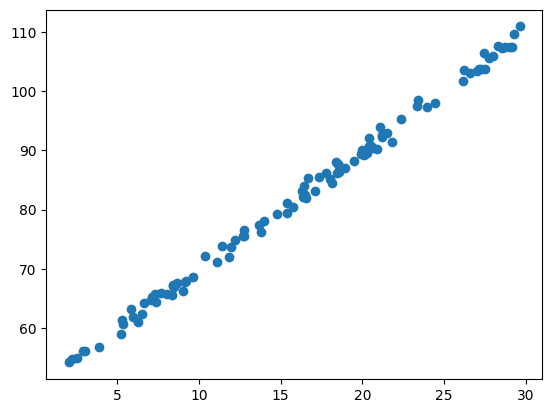

In [18]:
x = np.random.uniform(2, 30, 100)
y = np.random.normal(2*x + 50, 1, 100)
plt.scatter(x,y)

2. Fit a linear regression model to the data, **with no learnable intercept** (i.e. fix it to zero), and plot the predictions of the resulting model compared to the data.

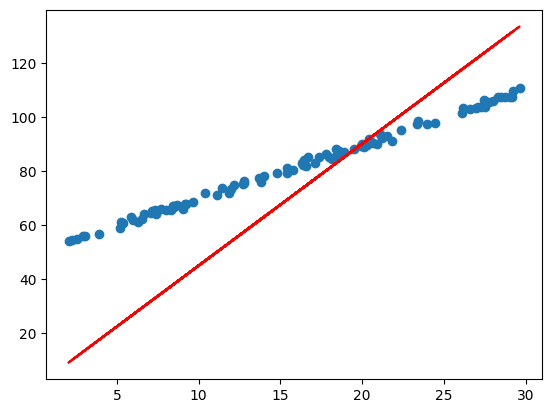

In [19]:
beta =  (1/(np.dot(x.T, x)))*np.dot(x.T,y)
plt.scatter(x,y)
plt.plot(x, beta*x, color = 'r')

3. Fit a linear regression model to the data, **with learnable intercept**, and plot the predictions of the resulting model compared to the data.

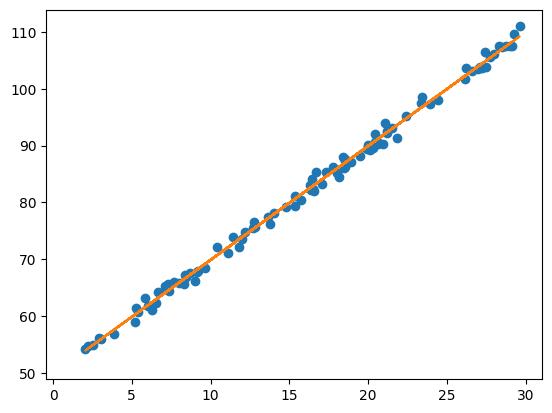

In [20]:
ones = np.ones(100)
x = np.column_stack((ones, x))

beta = np.dot(np.dot(np.linalg.inv(np.dot(x.T,x)), x.T), y)

plt.scatter(x[:,1],y)
plt.plot(x, beta[0] + beta[1]*x)

4. Fit a linear ridge regression model to the data, and plot the predictions of the resulting model compared to the data.

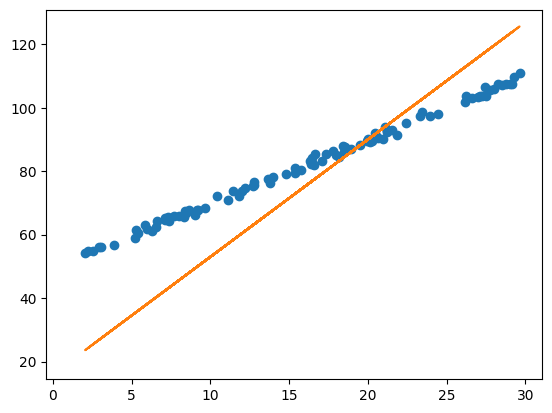

In [21]:
lambda_ridge = 40

# we use the following to compute the coefficients beta using the ridge regression:
# beta = [(X.T * X) + lambda*Id]^-1 * (X.T*y) 
# where X is the data provided with the first column all ones, and y is the variable to be predicted

beta = np.dot(np.linalg.inv(np.dot(x.T,x) + lambda_ridge*np.eye(2)), np.dot(x.T,y))

plt.scatter(x[:,1],y)
plt.plot(x, beta[0] + beta[1]*x)

**Exercise 2: Kernel regression on *periodic* data**
1. The following dataset is given. Plot it.

In [22]:
xkr = np.linspace(2, 30, 100)
ykr = xkr + 4 * np.sin(xkr) + 4 * np.random.rand(xkr.shape[0])

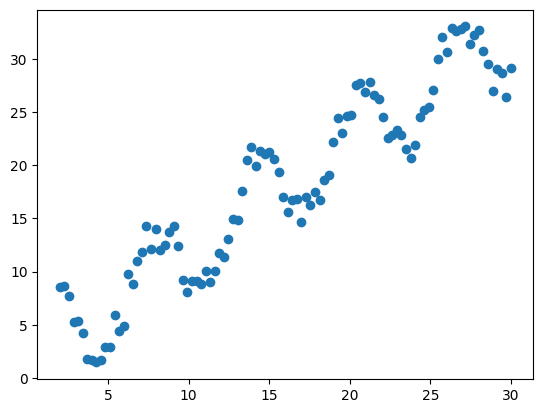

In [23]:
plt.scatter(xkr, ykr)

2. Define a function that computes the Gaussian kernel value between two vectors, represented as numpy arrays.

In [24]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(- (np.dot(x1-x2, x1-x2))/(2*sigma**2))

3. With the fuction just defined, compute the Gram matrix of the dataset. Use a Gaussian kernel with $\sigma=1$.

In [25]:
n = xkr.shape[0]
gram = np.empty([100,100])

for i in range(n):
    for j in range(n):
        gram[i][j] = gaussian_kernel(xkr[i],xkr[j],1)

4. Fit a kernel ridge regression model to the data, and plot the resulting model compared to the data.

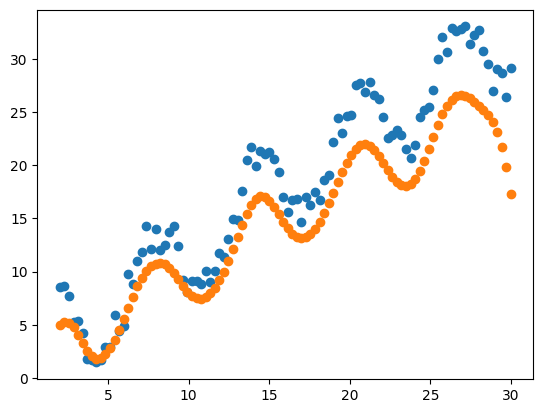

In [26]:
lambda_ridge = 2

alpha = np.dot(np.linalg.inv(gram + lambda_ridge*np.eye(100)), ykr)

# prediction on xj are obtained with yjhat = f(xj) = sum over i=1,n of alpha_i K(xi,xj)

# we use the following to compute alpha = (alpha1,...,alphan)=(gram_matrix + lambda*identity_n)^-1 * y 

yhat = np.empty(100)

for j in range(100):
    sum = 0
    for i in range(100):
        sum += alpha[i] * gram[i][j] 
        yhat[j] = sum

plt.scatter(xkr, ykr)
plt.scatter(xkr, yhat)

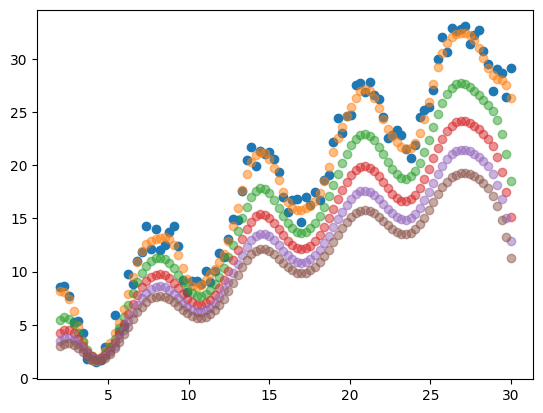

In [27]:
plt.scatter(xkr, ykr)

for lambda_ridge in np.linspace(0.1,6,5):
    alpha = np.dot(np.linalg.inv(gram + lambda_ridge*np.eye(100)), ykr)
    yhat = np.empty(100)
    for j in range(100):
        sum = 0
        for i in range(100):
            sum += alpha[i] * gram[i][j] 
            yhat[j] = sum

    plt.scatter(xkr, yhat, alpha= 0.5)

### *Kernel PCA* and the *Radial Basis Function* (RBF) Kernel

Let us briefly recap the key concepts of PCA. We have a dataset $X\in R^{N\times d}$, and we want to find a new basis $Z\in R^{N\times d}$ such that the variance of the projected data is maximized. This is equivalent to finding the eigenvectors of the covariance matrix $C=X^{T}X$.

This requires the data to be centered, i.e. $X_{i}^{(j)}-\mu_{j} \rightarrow X_{i}^{(j)}$, where $\mu_{j}=\frac{1}{N}\sum_{i=1}^{N}X_{i}^{(j)}$ is the mean of the $j$-th feature.

We can also write the eigenvalue problem in components, as follows: $Cz_{j}=\lambda_{j}z_{j}$, where $z_{j}$ is the $j$-th eigenvector and $\lambda_{j}$ is the corresponding eigenvalue. The eigenvectors are orthogonal, i.e. $z_{j}^{T}z_{k}=0$ for $j\neq k$.

Moving to the kernelized case, we operate the substitution $x\rightarrow \phi(x)$, and the eigenvalue problem becomes $C_{K}v=\lambda v$ with $C_{K}=\frac{1}{N}\sum_{i}\phi(x_{i})\phi^{T}(x_{i})$, $\phi(\cdot)$ being a generic feature map.

One can prove that solutions of the eigenvalue problem are in the form $v=\sum_{i}\alpha_{i}\phi(x_{i})$. Multiplying both sides of $C_{K}v=\lambda v$ by $\phi(x_{k})$ and substituting, we obtain $N\lambda \alpha=K \alpha$.

Such reasoning still requires normalization, i.e. $ \phi(x)-\frac{1}{d}\sum_{i}(\phi(x))_{i} \rightarrow \phi(x)$. The resulting kernel $K$ is in the form $K := K-2Id_{1/n}K + Id_{1/n}K Id_{1/n}$ with $Id_{1/n}$ the matrix with entries $1/n$.

A more thorough explanation can be found in [this blogpost](https://sdat.ir/en/sdat-blog/python-kernel-tricks-and-nonlinear-dimensionality-reduction-via-rbf-kernel-pca).


**Exercise 3: Kernel PCA**
1. A *Half Moons* dataset of $100$ points is given below. Plot it.

In [6]:
xhm, yhm = make_moons(n_samples=100, random_state=123)

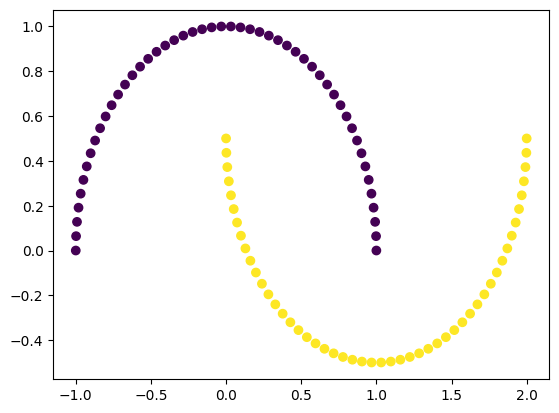

In [7]:
plt.scatter(xhm[:,0], xhm[:,1], c = yhm)

2. Apply the PCA algorithm to the dataset, and plot the resulting projection using the first 2 principal components.
**Hint**: you can use the `PCA` class from `sklearn.decomposition`.

In [8]:
# use the code from unsupervised learning

def my_PCA(X_std, k):
    """
    X: dataframe
        dataframe with n observation and p features, assumed to be already centered (nxp)
    k: int
        number of principal components we want to project on
    output: array-shape
        return the "projection matrix": this is a (p x k) matrix that is used to projecs a dataset of n observations and p features
        to a dataset with n observations and k feature; in particular, the "k most imporant" features of the initial dataset.
        (important according to "preserving varianca" paradigma)
        Remark:
        to actually projects, we have to compute the dot product between the initial nxp dataset and the output (pxk) matrix of this function my_PCA.
        Example:
        X = my_initial_nxp_dataset #assume X is centered
        find_best_k(X) #used to find the best k, call it k_bar
        proj_mtrx = my_PCA(X, k_bar)
        proj_dataset = X.dot(proj_mtrx) # this is the entire initial dataset projected onto the k PCs, so it is a nxk matrix.
    """
  
    cov_mat = np.cov(X_std.T)

    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    #print('eig_val:', eig_vals)
    #print('eig_vecs:', eig_vecs)

    sorted_indices = np.argsort(eig_vals)[::-1]
    sorted_eigvecs = eig_vecs[:,sorted_indices]
    #print('sorted_indeces:', sorted_indices)
    #print('sorted_eigvec:', sorted_eigvecs)
    

    #num_features = X_std.shape[1]
    #print(num_features)
    explained_variance_ratio = eig_vals / np.sum(eig_vals)
    fidelity_variance_ratio = np.cumsum(explained_variance_ratio)
    
    top_k_eigvecs = sorted_eigvecs[:k]
    #print(top_k_eigvecs.shape)
    #print('top_k:', top_k_eigvecs)

    #print('shape', top_k_eigvecs.T.shape)

    return top_k_eigvecs.T

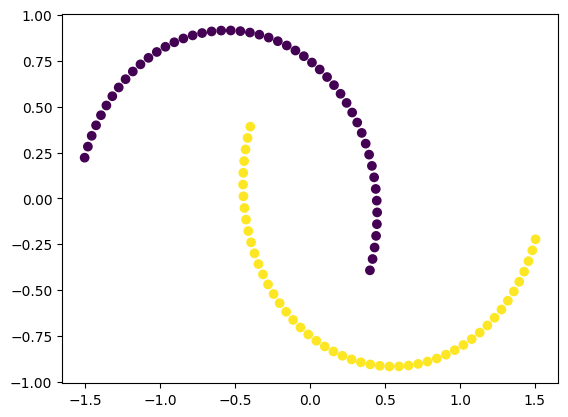

In [9]:
X =  xhm - xhm.mean(axis=0)
proj_xhm2 = X.dot(my_PCA(X, 2))

plt.scatter(proj_xhm2[:,0], proj_xhm2[:,1], c = yhm)

3. Repeat the previous step, but plotting just the first principal component. Comment on the separability of the two classes.

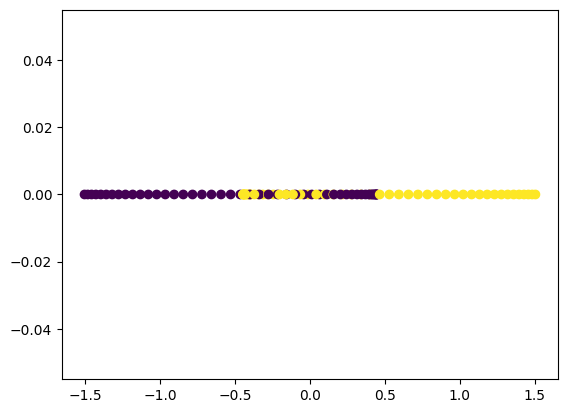

In [10]:
proj_xhm1 = X.dot(my_PCA(X, 1))

plt.scatter(proj_xhm1, np.zeros(100), c = yhm)

4. Implement a function that computes the *Radial Basis* PCA algorithm of the dataset, given as a NumPy array.

In [60]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(- (np.dot(x1-x2, x1-x2))/(2*(sigma**2)))

In [62]:
def kpca(x_data, gamma, n_components):
    """
    Implementation of a RBF kernel PCA.

    Arguments:
        x_data: A nxp dataset as NumPy array where the samples are stored as rows (n),
           and the attributes defined as columns (p).
        gamma: float
            The free parameter (coefficient) for the RBF kernel.
        n_components: int
            The number of components to be returned.


    output: array-shape
        return the "projection matrix": this is a (p x k) matrix that is used to projecs a dataset of n observations and p features
        to a dataset with n observations and k feature; in particular, the "k most imporant" features of the initial dataset.
        (important according to "preserving varianca" paradigma)
        Remark:
        to actually projects, we have to compute the dot product between the initial nxp dataset and the output (pxk) matrix of this function my_PCA.
        Example:
        X = my_initial_nxp_dataset #assume X is centered
        find_best_k(X) #used to find the best k, call it k_bar
        proj_mtrx = my_PCA(X, k_bar)
        proj_dataset = X.dot(proj_mtrx) # this is the entire initial dataset projected onto the k PCs, so it is a nxk matrix.
    """
    # center the data
    #x_data = x_data - x_data.mean(axis=0)

    print(x_data.shape)
    K = np.empty([x_data.shape[0], x_data.shape[0]])
    for i in range(x_data.shape[0]):
        for j in range(x_data.shape[0]):
            # compute euclidean distance between each pait of points
            K[i][j] = gaussian_kernel(x_data[i], x_data[j], sigma = gamma)

            #mtrx_distance[i,j] = (x_data[i][0] - x_data[j][0])**2 + (x_data[i][1] - x_data[j][1])**2
    print(K)
    print(K.shape)
    #K = np.exp(- mtrx_distance/(2*gamma**2))

    """
    # Center the Gram matrix
    N = K.shape[0]
    ones_over_n = np.ones((N, N)) / N
    K = (
        K
        - ones_over_n.dot(K)
        - K.dot(ones_over_n)
        + ones_over_n.dot(K).dot(ones_over_n)
    )
    """

    eig_vals, eig_vecs = np.linalg.eig(K)
    

    sorted_indices = np.argsort(eig_vals)[::-1]
    sorted_eigvecs = eig_vecs[:,sorted_indices]
    
    top_k_eigvecs = sorted_eigvecs[:n_components]

    return top_k_eigvecs

5. Apply the function just defined to the dataset, and plot the resulting projection using the first 2 principal components.

(100, 2)
[[1.         0.629512   0.57143032 ... 0.85051614 0.53781919 0.64812139]
 [0.629512   1.         0.75453724 ... 0.39185645 0.43153783 0.96782389]
 [0.57143032 0.75453724 1.         ... 0.2696805  0.81988895 0.61778954]
 ...
 [0.85051614 0.39185645 0.2696805  ... 1.         0.25381808 0.46248392]
 [0.53781919 0.43153783 0.81988895 ... 0.25381808 1.         0.33419754]
 [0.64812139 0.96782389 0.61778954 ... 0.46248392 0.33419754 1.        ]]
(100, 100)


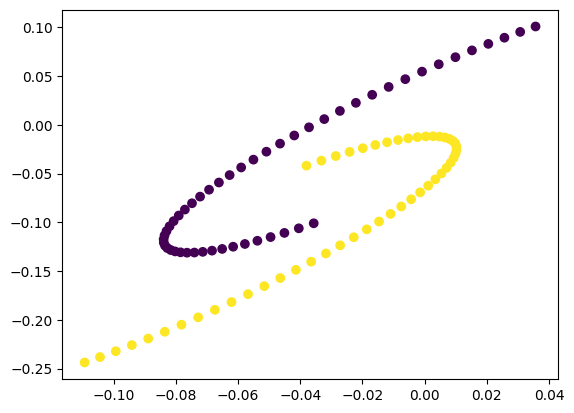

In [63]:

proj_mtrx = kpca(x_data = xhm, gamma = 1, n_components= 2)
projected_data = xhm.dot(proj_mtrx)

first_comp = [projected_data[i][0] for i in range(xhm.shape[0])]
second_comp = [projected_data[i][1] for i in range(xhm.shape[0])]

plt.scatter(first_comp, second_comp, c = yhm)

6. Repeat the previous step, but plotting just the first principal component. Comment on the separability of the two classes.


In [66]:
proj_mtrx = kpca(x_data = xhm, gamma = 1, n_components= 1)
print(xhm.shape)
print(proj_mtrx.shape)

projected_data = xhm.dot(proj_mtrx)

first_comp = [projected_data[i][0] for i in range(xhm.shape[0])]
#second_comp = [projected_data[i][1] for i in range(xhm.shape[0])]

plt.scatter(first_comp, np.zeros([xhm.shape[0]]), c = yhm)

(100, 2)
[[1.         0.629512   0.57143032 ... 0.85051614 0.53781919 0.64812139]
 [0.629512   1.         0.75453724 ... 0.39185645 0.43153783 0.96782389]
 [0.57143032 0.75453724 1.         ... 0.2696805  0.81988895 0.61778954]
 ...
 [0.85051614 0.39185645 0.2696805  ... 1.         0.25381808 0.46248392]
 [0.53781919 0.43153783 0.81988895 ... 0.25381808 1.         0.33419754]
 [0.64812139 0.96782389 0.61778954 ... 0.46248392 0.33419754 1.        ]]
(100, 100)
(100, 2)
(1, 100)


ValueError: shapes (100,2) and (1,100) not aligned: 2 (dim 1) != 1 (dim 0)